In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal
from scipy.interpolate import interp1d
from scipy.linalg import hankel

import math

In [32]:
### ====  1. Load the raw data ============

datadir = 'data_RGCs/'
stim = np.squeeze(loadmat(f'{datadir}Stim.mat')['Stim']) # contains stimulus value at each frame
stim_times = np.squeeze(loadmat(f'{datadir}stimtimes.mat')['stimtimes']) # contains time in seconds at each frame (120 Hz)
all_spike_times = [np.squeeze(x) for x in np.squeeze(loadmat(f'{datadir}SpTimes.mat')['SpTimes'])] # time of spikes for 4 neurons (in units of stim frames)
num_cells = len(all_spike_times)

print(f'length of stimulus: {stim.shape}')
print(f'Number of spikes for each of 4 neurons: {" ".join([str(x.size) for x in all_spike_times])}')

# Compute some basic statistics on the stimulus
dt_stim = stim_times[1] - stim_times[0] # time bin size

# Pick a cell to work with
cell_idx = 3
spike_times = all_spike_times[cell_idx]

length of stimulus: (144051,)
Number of spikes for each of 4 neurons: 31528 21553 49954 43126


In [33]:
### == 2. Upsample to get finer timescale representation of stim and spikes === 

# If we want to compare how MAP estimation of the stimulus changes with and without
# spike history to reflect the importance of the specific timing of spikes
# we should use bins that can only contain single spikes
# that way, samples more accurately reflect true inter-spike interval

# Now upsample to finer temporal grid
upsamp_factor = 5 # divide each time bin by this factor
dt_fine = dt_stim/upsamp_factor # use bins 100 time bins finer
tt_fine = np.linspace(dt_fine/2, (len(stim)+1)*dt_stim, int((len(stim)*dt_stim)/dt_fine)+1, endpoint=True).T # fine time grid for upsampled stim
# Create binned spike data containing max one spike per bin
spikes_binned = np.histogram(spike_times,tt_fine)[0].T

# Separate data into training and testing
# Let's use 3/4 the data for calculating the filter, and we will use
# 1/4 of the data to perform MAP estimation
num_train_bins = round(len(stim)*.75)
testing_groups = [np.arange(round(len(stim)*.25)),
                  np.arange(round(len(stim)*.25),round(len(stim)*.5)),
                  np.arange(round(len(stim)*.5),round(len(stim)*.75)),
                  np.arange(round(len(stim)*.75),round(len(stim)))]
testing_groups_fine = [np.arange(round(len(stim)*.25)*upsamp_factor),
                       np.arange(round(len(stim)*.25)*upsamp_factor,round(len(stim)*.5)*upsamp_factor),
                       np.arange(round(len(stim)*.5)*upsamp_factor,round(len(stim)*.75)*upsamp_factor),
                       np.arange(round(len(stim)*.75)*upsamp_factor,round(len(stim))*upsamp_factor)]
print(f'Training using {num_train_bins/120:.2f} seconds of data')
stim_train = np.delete(stim, testing_groups[2]) # reduce stimulus to selected time bins
spikes_binned_train = np.delete(spikes_binned, testing_groups_fine[2]) # reduce spikes

Training using 900.32 seconds of data


In [34]:
### ===== 2.98 Create log-likelihood functions ===========
# Let's define some functions that calculates log-likelihood, gradient, and the hessian
# so we can pass them to scipy's automatic solver that will give us
# the optimized parameter fit using ML. This function is taken from tutorial 4.

def neglogli_poissGLM(thetas, xx, yy, dt_bin, upsamp=1, xx2=None):
    """ Compute negative log-likelihood of data under Poisson GLM model with
        exponential nonlinearity. Because we want to only upsample part of the design matrix
        This time we will not return gradient and hessian, for simplicity.
        
        Args
        ----
        thetas: ndarray
            parameter vector
        xx: ndarray
            design matrix
        yy: ndarray (T X 1)
            response variable (spike count per time bin)
        dt_bin: float
            time bin size used
        vals_to_return: int
            which of negative log-likelihood (0), gradient (1), or hessian (2) to return.
            3 returns all three values. This is necessary due to scipy.optimize.minimize
            requiring the three separate functions with a single return value for each.
        upsamp: int
            How many frames to upsample the stimulus by when computing log-likelihood.
            Useful if you are predicting spikes on a finer temporal resolution than you
            want your filter to be on.
        xx2: ndarray
            portion of design matrix that does not need to be upsampled (spike history)
        
            
        Returns
        -------
        neglogli: float
            negative log likelihood of spike train
    """
    
    # Compute GLM filter output and conditional intensity
    vv = xx @ thetas[:xx.shape[1]] # filter output
    if upsamp > 1:
        vv = np.repeat(vv, upsamp) # if we need to upsample, do so by repeating elements
    if xx2 is not None:
        vv2 = xx2 @ thetas[xx.shape[1]:]
        vv += vv2
    rr = np.exp(vv) * dt_bin # conditional intensity (per bin)

    # ---------  Compute log-likelihood -----------
    Trm1 = -vv.T @ yy; # spike term from Poisson log-likelihood
    Trm0 = np.sum(rr)  # non-spike term 
    neglogli = Trm1 + Trm0
    
#     # ---------  Compute Gradient -----------------
#     dL1 = -xx.T @ yy # spiking term (the spike-triggered average)
#     dL0 = xx.T @ rr # non-spiking term
#     dL = dL1 + dL0
    
#     # ---------  Compute Hessian -------------------
#     H = xx.T @ (xx * np.transpose([rr])) # non-spiking term
    
    return neglogli

In [35]:
### ==== 2.99 create log posterior functions ======
def neglogposterior(thetas, neglogli_fun, Cinv):
    """ Compute negative log-posterior given a negative log-likelihood function
        and zero-mean Gaussian prior with inverse covariance 'Cinv'.
        
        # Compute negative log-posterior by adding quadratic penalty to log-likelihood
        
        Args
        ----
        thetas: ndarray (d X 1)
            parameter vector
        neglogli_fun: callable
            function that computes negative log-likelihood, gradient, and hessian.
        Cinv: ndarray (d X d)
            inverse covariance of prior
        vals_to_return: int
            which of negative log-posterior (0), gradient (1), or hessian (2) to return.
            3 returns all three values. This is necessary due to scipy.optimize.minimize
            requiring the three separate functions with a single return value for each.
        
        Returns
        -------
        neglogpost: float
            negative log posterior
        grad: ndarray (d X 1)
            gradient
        H: ndarray (d X d)
            Hessian (second derivative matrix)
    """

    neglogpost = neglogli_fun(thetas)
    neglogpost = neglogpost + .5 * thetas.T @ Cinv @ thetas       
#     grad = grad + Cinv @ thetas
#     H = H + Cinv
    
    return neglogpost

In [6]:
### ==== 3a. Obtain stimulus filter from model without spike history=======
from scipy.optimize import minimize
# For now, we will just obtain the filter from a model using only the stimulus
ntfilt = 20

# Construct design matrix
padded_stim = np.hstack((np.zeros(ntfilt-1), stim_train[:-ntfilt+1]))   # pad early bins of stimulus with zero
design_mat_stim = np.hstack((hankel(padded_stim, padded_stim[-ntfilt:]), np.ones((num_train_bins,1))))

# Define train and test log-likelihood funcs
neglogli_train_func = lambda prs : neglogli_poissGLM(prs, design_mat_stim, spikes_binned_train, dt_fine, upsamp=upsamp_factor)

optimizer = minimize(fun=neglogli_train_func, x0=np.zeros(ntfilt+1), method='L-BFGS-B', tol=1e-6, options={'disp':True})
wmap_stim = optimizer.x[:-1]
const_stim = optimizer.x[-1]

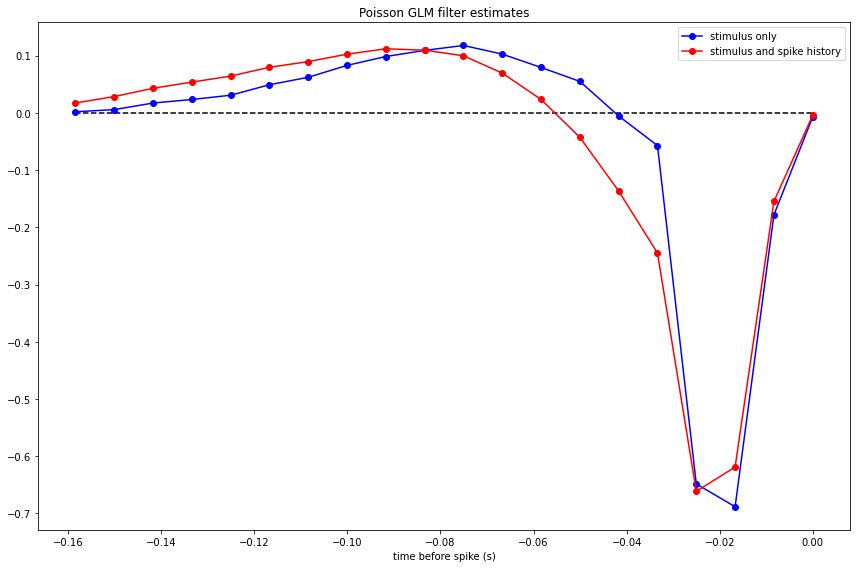

In [7]:
### ==== 3a. Obtain stimulus filter from model with spike history=======
from scipy.linalg import norm
# For now, we will just obtain the filter from a model using only the stimulus
nthist = 20 * upsamp_factor

# Build spike-history design matrix
padded_spikes = np.hstack((np.zeros(nthist), spikes_binned_train[:-1]))
design_mat_spikes = np.hstack((hankel(padded_spikes[:-nthist+1], padded_spikes[-nthist:]), np.ones((num_train_bins*upsamp_factor,1))))

# Define train and test log-likelihood funcs
# I'm positioning the column of ones always at the end for convenience
neglogli_train_func = lambda prs : neglogli_poissGLM(prs, design_mat_stim[:,:-1], spikes_binned_train, dt_fine, upsamp=upsamp_factor, xx2=design_mat_spikes)

optimizer = minimize(fun=neglogli_train_func, x0=np.zeros(ntfilt+nthist+1), method='L-BFGS-B', tol=1e-6, options={'disp':True})
wmap_both = optimizer.x[:ntfilt]
sp_hist_filt = optimizer.x[ntfilt:-1]
const_both = optimizer.x[-1]

# Let's plot the filter
ttk = np.arange(-ntfilt+1,1)*dt_stim
fig, ax1 = plt.subplots()
fig.set_size_inches(12,8)
ax1.plot(ttk,ttk*0, 'k--')
ax1.plot(ttk, wmap_stim/norm(wmap_stim), 'o-', c='b', label='stimulus only')
ax1.plot(ttk, wmap_both/norm(wmap_both), 'o-', c='r', label='stimulus and spike history')
ax1.set_title('Poisson GLM filter estimates')
ax1.set_xlabel('time before spike (s)')
plt.legend()
plt.tight_layout()

In [36]:
def sigmoid_to_bounds(data, lower, upper):
#     sig_data = 1/(1+np.exp(-1*data))
#     trans_data = lower + (upper-lower)*sig_data
    
    return data

In [37]:
### ===== 5a. Create log-likelihood functions ===========
# We need to modify our log-likelihood function to allow us to
# add the information we already know about the spikes to
# our prediction. There are a few ways of doing this, but
# we are going to precompute it and just pass it to the function.

def neglogli_forMAP(thetas, xx, yy, dt_bin, known_info, pre_stim, post_stim, upsamp=1):
    """ Compute negative log-likelihood of data under Poisson GLM model with
        exponential nonlinearity. Because we want to only upsample part of the design matrix
        This time we will not return gradient and hessian, for simplicity.
        
        Args
        ----
        thetas: ndarray
            parameter vector
        xx: ndarray
            design matrix
        yy: ndarray (T X 1)
            response variable (spike count per time bin)
        dt_bin: float
            time bin size used
        vals_to_return: int
            which of negative log-likelihood (0), gradient (1), or hessian (2) to return.
            3 returns all three values. This is necessary due to scipy.optimize.minimize
            requiring the three separate functions with a single return value for each.
        known_info: ndarray (T X 1)
            Information we already know about the yy variable.
        pre_stim: ndarray
            The stimulus right before the block we are predicting.
        post_stim: ndarray
            The stimulus right after the block we are predicting.
        upsamp: int
            How many frames to upsample the stimulus by when computing log-likelihood.
            Useful if you are predicting spikes on a finer temporal resolution than you
            want your filter to be on.
        
            
        Returns
        -------
        neglogli: float
            negative log likelihood of spike train
    """
    
    # Compute GLM filter output and conditional intensity
    # Combine thetas we are fitting with known stimulus
    thetas = sigmoid_to_bounds(thetas, -0.48, 0.48)
    thetas = np.concatenate((pre_stim, thetas, post_stim))
    vv = xx @ thetas # filter output
    if upsamp > 1:
        vv = np.repeat(vv, upsamp) # if we need to upsample, do so by repeating elements
    
    vv += known_info # only the middle part is predictable from the thetas we passed.
    rr = np.exp(vv) * dt_bin # conditional intensity (per bin)

    # ---------  Compute log-likelihood -----------
    Trm1 = -vv.T @ yy; # spike term from Poisson log-likelihood
    Trm0 = np.sum(rr)  # non-spike term 
    neglogli = Trm1 + Trm0
    
#     # ---------  Compute Gradient -----------------
#     dL1 = -xx.T @ yy # spiking term (the spike-triggered average)
#     dL0 = xx.T @ rr # non-spiking term
#     dL = dL1 + dL0
    
#     # ---------  Compute Hessian -------------------
#     H = xx.T @ (xx * np.transpose([rr])) # non-spiking term
    
    return neglogli

In [38]:
### ===== 5b. Perform MAP estimation =====
import os
import scipy
from scipy.sparse import diags
from scipy.linalg import toeplitz
from scipy.optimize import minimize
# There is a lot going on in this cell, as I wanted to do everything in one loop.
# First we precompute what we know about the spikes we are using
# to fit our stimulus, then we run our minimization, including a prior
# gaussian with the same variance as the stimulus
# and we are keeping track of this for all blocks of testing data

fold_stim_pred = []
fold_both_pred = []
fold_stim_true = []

for fold in np.arange(4):
    stim_train = np.delete(stim, testing_groups[fold]) # reduce stimulus to selected time bins
    spikes_binned_train = np.delete(spikes_binned, testing_groups_fine[fold]) # reduce spikes
    num_train_bins = len(stim_train)
    
    ### ==== 3a. Obtain stimulus filter from model without spike history=======
    
    # For now, we will just obtain the filter from a model using only the stimulus
    ntfilt = 20

    # Construct design matrix
    padded_stim = np.hstack((np.zeros(ntfilt-1), stim_train[:-ntfilt+1]))   # pad early bins of stimulus with zero
    design_mat_stim = np.hstack((hankel(padded_stim, padded_stim[-ntfilt:]), np.ones((stim_train.size,1))))

    # Define train and test log-likelihood funcs
    neglogli_train_func = lambda prs : neglogli_poissGLM(prs, design_mat_stim, spikes_binned_train, dt_fine, upsamp=upsamp_factor)

    optimizer = minimize(fun=neglogli_train_func, x0=np.zeros(ntfilt+1), method='L-BFGS-B', tol=1e-6, options={'disp':True})
    wmap_stim = optimizer.x[:-1]
    const_stim = optimizer.x[-1]
    
    ### ==== 3a. Obtain stimulus filter from model with spike history=======
    
    # For now, we will just obtain the filter from a model using only the stimulus
    nthist = 20 * upsamp_factor

    # Build spike-history design matrix
    padded_spikes = np.hstack((np.zeros(nthist), spikes_binned_train[:-1]))
    design_mat_spikes = np.hstack((hankel(padded_spikes[:-nthist+1], padded_spikes[-nthist:]), np.ones((stim_train.size*upsamp_factor,1))))

    # Define train and test log-likelihood funcs
    # I'm positioning the column of ones always at the end for convenience
    neglogli_train_func = lambda prs : neglogli_poissGLM(prs, design_mat_stim[:,:-1], spikes_binned_train, dt_fine, upsamp=upsamp_factor, xx2=design_mat_spikes)

    optimizer = minimize(fun=neglogli_train_func, x0=np.zeros(ntfilt+nthist+1), method='L-BFGS-B', tol=1e-6, options={'disp':True})
    wmap_both = optimizer.x[:ntfilt]
    sp_hist_filt = optimizer.x[ntfilt:-1]
    const_both = optimizer.x[-1]

    # Let's plot the filter
    ttk = np.arange(-ntfilt+1,1)*dt_stim





    # Let's assemble our testing data into blocks that we will predict one by one
    spikes_test = spikes_binned[testing_groups_fine[fold]]
    stim_test = stim[testing_groups[fold]]
    pred_length = 100 # we will reconstruct 100 frames of stimulus at a time
    num_preds = len(spikes_test)//(pred_length*upsamp_factor)
    spikes_test = np.reshape(spikes_test[:num_preds*pred_length*upsamp_factor], (num_preds, pred_length*upsamp_factor))
    stim_test = np.reshape(stim_test[:(len(stim_test)//pred_length)*pred_length], (len(stim_test)//pred_length, pred_length))

    stim_predictions_stim = np.zeros(stim_test.shape)
    stim_predictions_both = np.zeros(stim_test.shape)

    ### Now we can make our design matrices, as per the cell above this one
    # but only solving for the current stimulus block. Just as before,
    # we will only upsample after projecting the filters onto the stimulus
    first_column = np.zeros((pred_length + 2*(ntfilt-1)))
    first_column[0] = wmap_stim[0]
    first_row = np.zeros((pred_length + 2*(ntfilt-1)))
    first_row[:ntfilt] = wmap_stim
    MAP_design_stim = toeplitz(first_column, first_row)
    #     plt.imshow(MAP_design_stim)

    first_column = np.zeros((pred_length + 2*(ntfilt-1)))
    first_column[0] = wmap_both[0]
    first_row = np.zeros((pred_length + 2*(ntfilt-1)))
    first_row[:ntfilt] = wmap_both
    MAP_design_both = toeplitz(first_column, first_row)
    bounds = [(-4.8, 4.8) for x in range(pred_length)]
    cons = {'type': 'ineq', 'fun': lambda thetas : int(np.amax(thetas) > 0.48)}

    for block in np.arange(1, num_preds-1): # skip first and last, as we will need edge case info, num_preds
    #     print(f'Working on stimulus block number {block}', end='\t')
        # we need a little more info on either side of our window to account for edge cases
        spikes_to_pred = np.concatenate((spikes_test[block-1][-(ntfilt-1)*upsamp_factor:],
                                         spikes_test[block],
                                         spikes_test[block+1][:(ntfilt-1)*upsamp_factor]))

        known_stim_pre = stim_test[block-1][-(ntfilt-1):] # known stim for predicting early spikes
        known_stim_post = stim_test[block+1][:ntfilt-1] # known stim for predicting late spikes

        known_spikes_stim = np.zeros(spikes_to_pred.shape) # to hold what we already know about the spikes
        known_spikes_both = np.zeros(spikes_to_pred.shape)

        # Now we need to also add what we know about the spikes from the constant
        # This represents the baseline stimulus-independent "mean" spikes
        known_spikes_stim += const_stim
        known_spikes_both += const_both

        # Finally, in the model with spike history, we also know
        # about spikes variance derived from their history, which is
        # also stimulus independent, so lets add that
        padded_spikes = np.hstack((spikes_test[block-1][-(nthist+(ntfilt-1)*upsamp_factor):-(ntfilt-1)*upsamp_factor],
                                   spikes_to_pred[:-1])) # this line is long because I decided not to pad with zeros
        design_mat_spikes = hankel(padded_spikes[:-nthist+1], padded_spikes[-nthist:])
        known_spikes_both += design_mat_spikes @ sp_hist_filt

        # Lets create our matrix that will serve as the gaussian prior
        # This is equivalent to the L2 regularization from before
        # where lambda is the inverse of the variance, which we will
        # set to be the variance of the training stimulus
        Dx1 = diags((np.ones((pred_length,1)) @ [[1,-1]]).T, np.arange(2), (pred_length-1, pred_length)).A
        Dx = Dx1.T @ Dx1 # computes squared diffs
        # Select smoothing penalty
        lam = np.var(stim_train)
        Cinv = lam*Dx # set inverse prior covariance

        ### Define train and test log-likelihood funcs
        neglogli_func_stim = lambda prs : neglogli_forMAP(prs, MAP_design_stim, spikes_to_pred, dt_fine, known_spikes_stim, known_stim_pre, known_stim_post, upsamp=upsamp_factor)
        neglogli_func_both = lambda prs : neglogli_forMAP(prs, MAP_design_both, spikes_to_pred, dt_fine, known_spikes_both, known_stim_pre, known_stim_post, upsamp=upsamp_factor)
        post_func_stim = lambda prs : neglogposterior(prs, neglogli_func_stim, Cinv)
        post_func_both = lambda prs : neglogposterior(prs, neglogli_func_both, Cinv)

        ### Run the minimization
        optimizer_stim = minimize(fun=neglogli_func_stim, x0=np.zeros(pred_length), tol=1e-6, options={'disp':False}, bounds=scipy.optimize.Bounds(-0.48, 0.48, keep_feasible=True))
        stim_predictions_stim[block] = sigmoid_to_bounds(optimizer_stim.x, -0.48, 0.48)
        optimizer_both = minimize(fun=neglogli_func_both, x0=np.zeros(pred_length), tol=1e-6, options={'disp':False}, bounds=scipy.optimize.Bounds(-0.48, 0.48, keep_feasible=True))
        stim_predictions_both[block] = sigmoid_to_bounds(optimizer_both.x, -0.48, 0.48)

    fold_stim_pred.append(stim_predictions_stim[1:-1])
    fold_both_pred.append(stim_predictions_both[1:-1])
    fold_stim_true.append(stim_test[1:-1])
    print(fold)
print('all done')

0
1
2
3
all done


<Figure size 432x288 with 0 Axes>

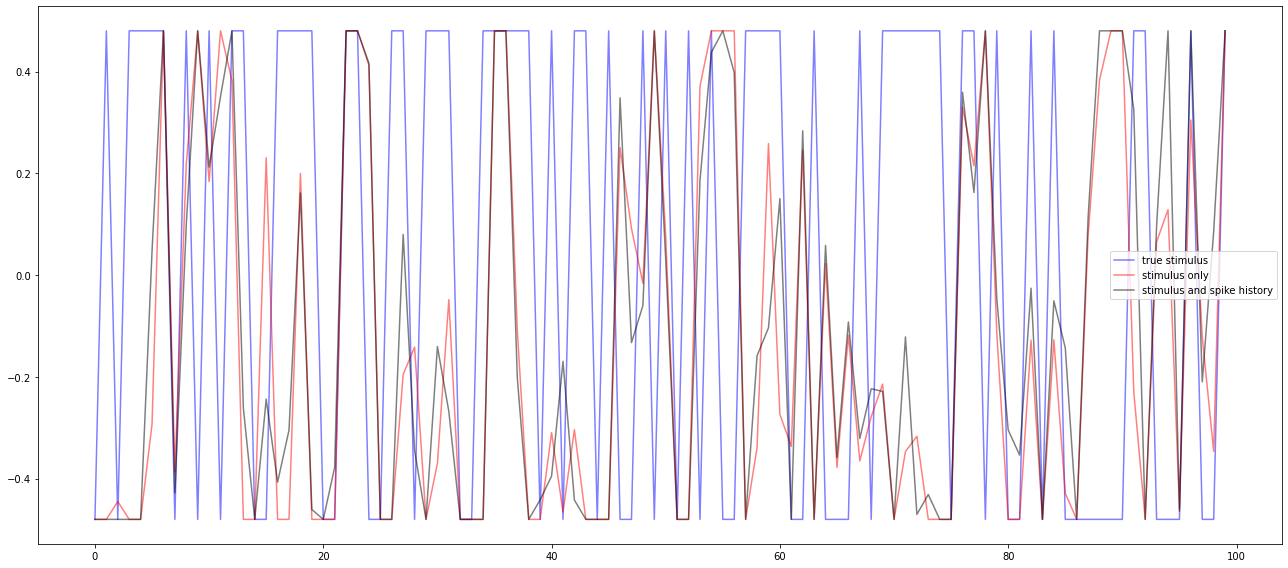

In [29]:
# Let's plot the filter
to_plot = -3
plt.clf()
plt.figure(figsize=[18,8])
plt.plot(stim_test[to_plot], c='b', alpha=.5, label='true stimulus')
plt.plot(stim_predictions_stim[to_plot], c='r', alpha=.5, label='stimulus only')
plt.plot(stim_predictions_both[to_plot], c='k', alpha=.5, label='stimulus and spike history')
plt.legend()
plt.tight_layout()
# print(pr(stim_test, map_stim))
# print(pr(stim_test, map_both))

In [30]:
from numpy.linalg import det

fold_stim_pred = np.concatenate(fold_stim_pred, axis=0)
fold_both_pred = np.concatenate(fold_both_pred, axis=0)
fold_stim_true = np.concatenate(fold_stim_true, axis=0)

pred_length = fold_stim_true.shape[1]

residuals_stim = np.abs(fold_stim_true - fold_stim_pred)
residuals_both = np.abs(fold_stim_true - fold_both_pred)
resid_cov_stim = np.ndarray((fold_stim_true.shape[0],pred_length,pred_length))
resid_cov_both = np.ndarray((fold_stim_true.shape[0],pred_length,pred_length))
stim_test_cov = np.ndarray((fold_stim_true.shape[0],pred_length,pred_length))
for x in np.arange(stim_test.shape[0]):
    resid_cov_stim[x] = residuals_stim[x][:,np.newaxis]*residuals_stim[x][:,np.newaxis].T
    resid_cov_both[x] = residuals_both[x][:,np.newaxis]*residuals_both[x][:,np.newaxis].T
    stim_test_cov[x] = stim_test[x][:,np.newaxis]*stim_test[x][:,np.newaxis].T
SNR_stim = np.log(det(np.mean(stim_test_cov, axis=0)) / det(np.mean(resid_cov_stim, axis=0)))
SNR_both = np.log(det(np.mean(stim_test_cov, axis=0)) / det(np.mean(resid_cov_both, axis=0)))
print(SNR_stim, SNR_both)

22.793011536650738 21.618449870232098


In [31]:
cell_results['stim_pred'].append(fold_stim_pred)
cell_results['both_pred'].append(fold_both_pred)
cell_results['stim_true'].append(fold_stim_true)
cell_results['stim_filt'].append(wmap_stim)
cell_results['both_filt'].append(wmap_both)
cell_results['sp_hist_filt'].append(sp_hist_filt)
cell_results['stim_const'].append(const_stim)
cell_results['both_const'].append(const_both)

In [10]:
import pickle
with open('cell_results.pkl', 'wb') as f:
    pickle.dump(cell_results, f)

In [27]:
stim_test = stim[testing_groups[2]]
padded_stim = np.hstack((np.zeros(ntfilt-1), stim_test[:-ntfilt+1]))   # pad early bins of stimulus with zero
design_mat_stim = np.hstack((hankel(padded_stim, padded_stim[-ntfilt:]), np.ones((padded_stim.size,1))))

spikes_test = spikes_binned[testing_groups_fine[2]]
padded_spikes = np.hstack((np.zeros(nthist), spikes_test[:-1]))
design_mat_spikes = np.hstack((hankel(padded_spikes[:-nthist+1], padded_spikes[-nthist:]), np.ones((spikes_test.size,1))))

wmap_temp = np.zeros(21)
wmap_temp[:-1] = wmap_stim
wmap_temp[-1] = const_stim
temp = design_mat_stim @ wmap_temp
temp = np.repeat(temp,5)
temp = np.exp(temp) *dt_fine
spikes_test = temp